In [0]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col

spark = SparkSession.builder.appName('GraphCancelAnalysis').getOrCreate()

### Import Data

In [0]:
df1 = spark.read.format("json").load("dbfs:/FileStore/shared_uploads/shengyan@uchicago.edu/airports1.json")

In [0]:
df1.show(10)

+----------+-------------+-------------+----+---+--------+----+------------+-----------+--------------------+--------+--------------------+
|Airport ID|         City|      Country|DBTZ|DST|IATA/FAA|ICAO|    Latitude|  Longitude|                Name|Timezone|        destinations|
+----------+-------------+-------------+----+---+--------+----+------------+-----------+--------------------+--------+--------------------+
|      7252|    Postville|       Canada|   A| -4|     YSO|CCD4|   54.910278| -59.785278|   Postville Airport|     223|   [5492, 188, 5502]|
|      6972|        Osubi|      Nigeria|   U|  1|     QRW|DNSU|        5.31|       5.45|       Warri Airport|      50|          [260, 273]|
|      4026|     Rockland|United States|   A| -5|     RKD|KRKD|  44.0601111|-69.0992303|Knox County Regio...|      56|              [3448]|
|      4027|  Jacksn Hole|United States|   A| -7|     JAC|KJAC|43.607333333| -110.73775|Jackson Hole Airport|    6451|        [3536, 3751]|
|      4024|       F

In [0]:
airports = df1.select("City", "Country", "Name", "IATA/FAA")
airports.show(5)

+-----------+-------------+--------------------+--------+
|       City|      Country|                Name|IATA/FAA|
+-----------+-------------+--------------------+--------+
|  Postville|       Canada|   Postville Airport|     YSO|
|      Osubi|      Nigeria|       Warri Airport|     QRW|
|   Rockland|United States|Knox County Regio...|     RKD|
|Jacksn Hole|United States|Jackson Hole Airport|     JAC|
|     Flores|    Guatemala|Mundo Maya Intern...|     FRS|
+-----------+-------------+--------------------+--------+
only showing top 5 rows



In [0]:
cancelled = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/shengyan@uchicago.edu/cancel.csv")
cancelled.show(5)

+---+----+-----+----------+---------+---------+------+----+--------+---+---+
|_c0|Year|Month|DayofMonth|DayOfWeek|FlightNum|Origin|Dest|Distance|src|dst|
+---+----+-----+----------+---------+---------+------+----+--------+---+---+
|  0|1987|   10|        12|        1|     1453|   BUR| OAK|   325.0|BUR|OAK|
|  1|1987|   10|        12|        1|     1454|   OAK| BUR|   325.0|OAK|BUR|
|  2|1987|   10|         6|        2|     1457|   LAX| SFO|   337.0|LAX|SFO|
|  3|1987|   10|        29|        4|     1459|   LAX| SFO|   337.0|LAX|SFO|
|  4|1987|   10|        22|        4|     1465|   BUR| OAK|   325.0|BUR|OAK|
+---+----+-----+----------+---------+---------+------+----+--------+---+---+
only showing top 5 rows



In [0]:
cancelled = cancelled.drop('_c0')

#### Create graph database

In [0]:
from functools import reduce
from pyspark.sql.functions import col, lit, when
from graphframes import *

In [0]:
airports = airports.withColumn("id",airports["IATA/FAA"])

cancelled = cancelled.withColumn("src", cancelled["Origin"])
cancelled = cancelled.withColumn("dst", cancelled["Dest"])

In [0]:
graph = GraphFrame(airports, cancelled)

#### Graph EDA

In [0]:
cancelDegree = graph.degrees.orderBy("degree", ascending=False)
cancelDegree = cancelDegree.toPandas()

In [0]:
graph.edges.filter("Origin='ORD'").show()

+----+-----+----------+---------+---------+------+----+--------+---+---+
|Year|Month|DayofMonth|DayOfWeek|FlightNum|Origin|Dest|Distance|src|dst|
+----+-----+----------+---------+---------+------+----+--------+---+---+
|1987|   10|        13|        2|      579|   ORD| STL|   258.0|ORD|STL|
|1987|   10|        10|        6|      610|   ORD| STL|   258.0|ORD|STL|
|1987|   10|        13|        2|      657|   ORD| STL|   258.0|ORD|STL|
|1987|   10|        30|        5|       33|   ORD| SEA|  1721.0|ORD|SEA|
|1987|   10|         4|        7|       74|   ORD| LGA|   733.0|ORD|LGA|
|1987|   10|        30|        5|      101|   ORD| LAX|  1745.0|ORD|LAX|
|1987|   10|        30|        5|      105|   ORD| LAX|  1745.0|ORD|LAX|
|1987|   10|        12|        1|      115|   ORD| LAX|  1745.0|ORD|LAX|
|1987|   10|         6|        2|      137|   ORD| SFO|  1846.0|ORD|SFO|
|1987|   10|        12|        1|      141|   ORD| PDX|  1739.0|ORD|PDX|
|1987|   10|        29|        4|      222|   ORD| 

#### Distribution of cancelled flights

In [0]:
#### Most cancelled flights
cancelRouteCount = graph.edges.groupBy("src", "dst").count().orderBy("count", ascending = False)

cancelRouteCount.show(10)

cancelRouteCount = cancelRouteCount.toPandas()

+---+---+-----+
|src|dst|count|
+---+---+-----+
|LAX|SFO|13135|
|SFO|LAX|12869|
|ORD|MSP|11085|
|MSP|ORD|11076|
|LGA|ORD|10690|
|EWR|ORD|10648|
|ORD|EWR|10240|
|ORD|LGA|10181|
|BOS|ORD| 8592|
|HOU|DAL| 8442|
+---+---+-----+
only showing top 10 rows



In [0]:
#### Cancelled flights by time
cancelMonthCount = graph.edges.groupBy('Month').count().orderBy("count", ascending = False)

cancelMonthCount.show(10)

cancelMonthCount = cancelMonthCount.toPandas()

+-----+------+
|Month| count|
+-----+------+
|    1|301756|
|   12|239558|
|    2|231362|
|    3|197778|
|    9|181759|
|    7|157595|
|    8|156117|
|    6|153804|
|   10|128173|
|   11|122171|
+-----+------+
only showing top 10 rows



In [0]:
#### Cancelled flights by day
cancelDayCount = graph.edges.groupBy("DayofWeek").count().orderBy("count", ascending = False)

cancelDayCount = cancelDayCount.toPandas()

#### Plot

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

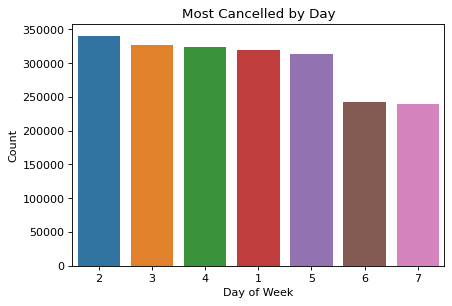

In [0]:
plt.figure(figsize=(6, 4), dpi=80)
ax = sns.barplot(x='DayofWeek', y = 'count', data=cancelDayCount)
plt.title('Most Cancelled by Day')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

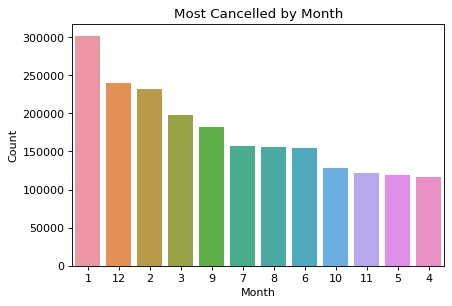

In [0]:
plt.figure(figsize=(6, 4), dpi=80)
ax = sns.barplot(x='Month', y = 'count', data=cancelMonthCount)
plt.title('Most Cancelled by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

In [0]:
cancelRouteCount['Flight Route'] = cancelRouteCount['src'] + '-->' + cancelRouteCount['dst']

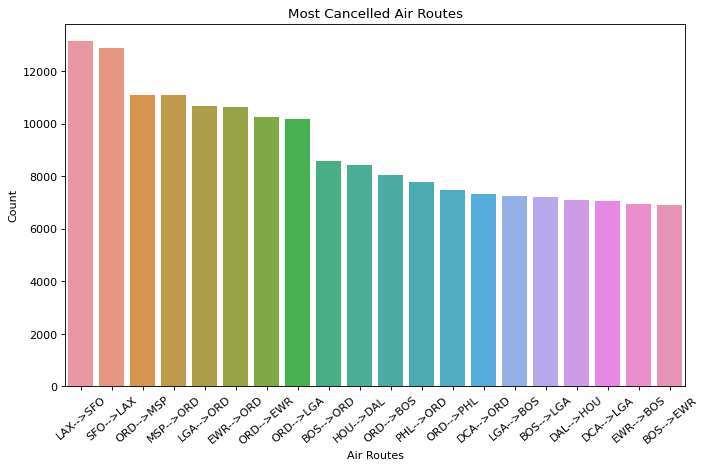

In [0]:
plt.figure(figsize=(10, 6), dpi=80)
cancelRouteCount_20 = cancelRouteCount[0:20]
ax4 = sns.barplot(x='Flight Route', y = 'count', data=cancelRouteCount_20)
plt.xticks(rotation=40)
plt.title('Most Cancelled Air Routes')
plt.xlabel('Air Routes')
plt.ylabel('Count')
plt.show()

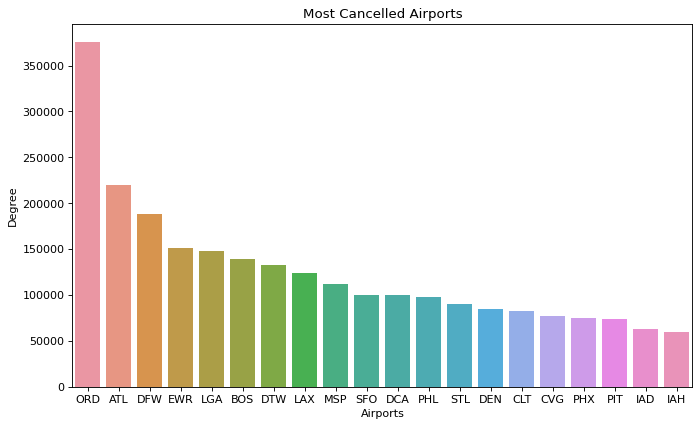

In [0]:
plt.figure(figsize=(10, 6), dpi=80)
cancelDegree_20 = cancelDegree[0:20]
ax3 = sns.barplot(x='id', y = 'degree', data=cancelDegree_20)
plt.title('Most Cancelled Airports')
plt.xlabel('Airports')
plt.ylabel('Degree')
plt.show()

#### Deeper Analysis

In [0]:
graph.triangleCount().orderBy("count", ascending=False).show()

+-----+-----------------+-------------+--------------------+--------+---+
|count|             City|      Country|                Name|IATA/FAA| id|
+-----+-----------------+-------------+--------------------+--------+---+
| 2768|          Atlanta|United States|Hartsfield Jackso...|     ATL|ATL|
| 2727|          Chicago|United States|  Chicago Ohare Intl|     ORD|ORD|
| 2486|Dallas-Fort Worth|United States|Dallas Fort Worth...|     DFW|DFW|
| 2442|       Cincinnati|United States|Cincinnati Northe...|     CVG|CVG|
| 2247|      Minneapolis|United States|Minneapolis St Pa...|     MSP|MSP|
| 2236|          Detroit|United States|Detroit Metro Way...|     DTW|DTW|
| 2188|          Houston|United States|George Bush Inter...|     IAH|IAH|
| 2080|           Newark|United States| Newark Liberty Intl|     EWR|EWR|
| 2005|           Denver|United States|         Denver Intl|     DEN|DEN|
| 1939|       Washington|United States|Washington Dulles...|     IAD|IAD|
| 1935|       Pittsburgh|United States

In [0]:
#Run PageRank until convergence to tolerance "tol".
results = graph.pageRank(resetProbability=0.15, tol= 0.01)
results.vertices.orderBy('pagerank',ascending=False).show()

+-----------------+-------------+--------------------+--------+---+------------------+
|             City|      Country|                Name|IATA/FAA| id|          pagerank|
+-----------------+-------------+--------------------+--------+---+------------------+
|          Chicago|United States|  Chicago Ohare Intl|     ORD|ORD| 84.56401591090294|
|          Atlanta|United States|Hartsfield Jackso...|     ATL|ATL|58.892428659827075|
|Dallas-Fort Worth|United States|Dallas Fort Worth...|     DFW|DFW|48.747252863953314|
|      Los Angeles|United States|    Los Angeles Intl|     LAX|LAX|33.529252343973106|
|           Newark|United States| Newark Liberty Intl|     EWR|EWR| 32.03331343333946|
|      Minneapolis|United States|Minneapolis St Pa...|     MSP|MSP|31.280016905994493|
|         New York|United States|          La Guardia|     LGA|LGA|29.553461338510978|
|          Detroit|United States|Detroit Metro Way...|     DTW|DTW| 29.53108162561986|
|    San Francisco|United States|  San Fran